# Fetch The Housing Data
    Fetch Housing Data from the web

In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()


In [2]:
fetch_housing_data()

# Load Housing Data
    Load CSV of housing data

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

# Plotting The Different Attributes

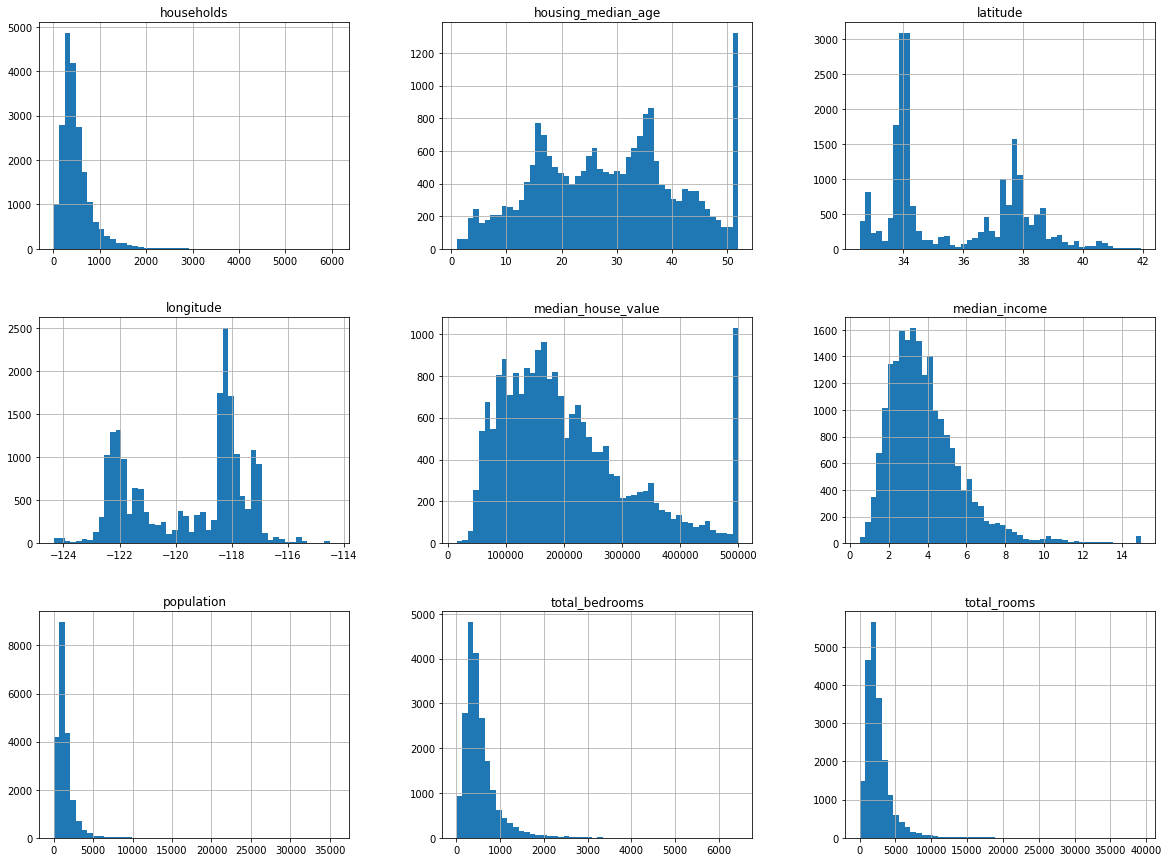

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

# Train Test Splitting

In [7]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [8]:
housing = train_set.copy()

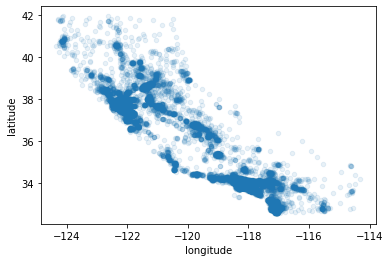

In [9]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

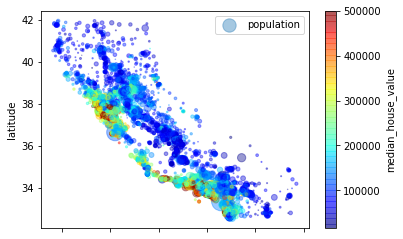

In [10]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing["population"]/100, label="population", 
            c = "median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

In [11]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.690647
total_rooms           0.133989
housing_median_age    0.103706
households            0.063714
total_bedrooms        0.047980
population           -0.026032
longitude            -0.046349
latitude             -0.142983
Name: median_house_value, dtype: float64

# Scatter matrix
Plots every numerical attribute against every other numerical attribute

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ee198d0>,
      dtype=object)

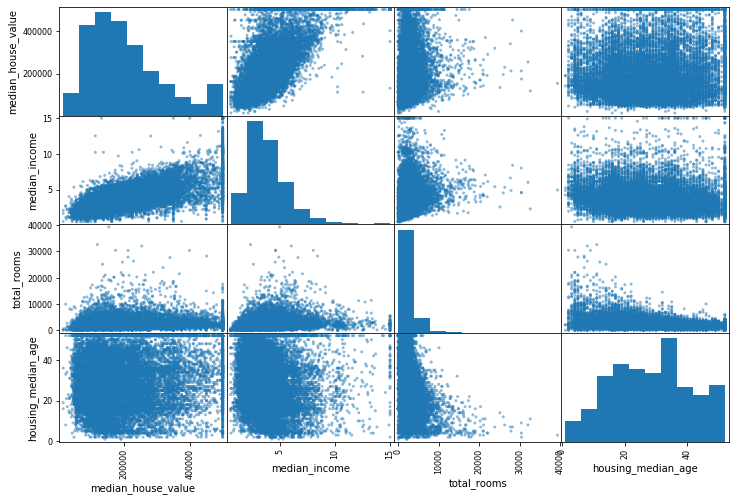

In [12]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))

Median Income clearly has the biggest correlation between the housing value so let's plot that

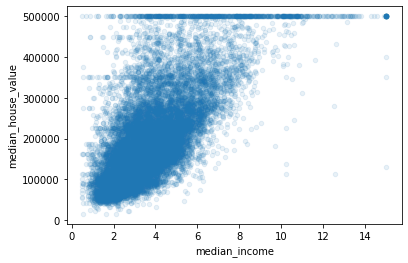

In [13]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

# Adjust Attributes
For example the total number of rooms in a district is not useful if you don't take into account the amount of households in order to get the 'rooms per househould'. same thing with number of bedrooms, should be compared with total number of rooms. Population per household is also a good attribute to use

In [14]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population']  / housing['households']

Now we can check the correlation matrix with the new values

In [15]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.690647
rooms_per_household         0.158485
total_rooms                 0.133989
housing_median_age          0.103706
households                  0.063714
total_bedrooms              0.047980
population_per_household   -0.022030
population                 -0.026032
longitude                  -0.046349
latitude                   -0.142983
bedrooms_per_room          -0.257419
Name: median_house_value, dtype: float64

# Data Cleaning
some values are missing in certain districts so we calculate the median of each attribute and use that to fill the missing data. sklearn does this with the Imputer class. This can only be computed on numerical values so we need a copy of the dataset without the text attribute ocean_proximity

First need to drop the median_housing_value as that is the "answer" column and we don't want that affected by transformations

In [16]:
housing = train_set.drop("median_house_value", axis=1)
housing_label = train_set["median_house_value"].copy()

Now we can impute

In [17]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")

#We need to drop the ocean proximity value by creating another copy

housing_num = housing.drop("ocean_proximity", axis=1)

#Fit the Imputer

imputer.fit(housing_num)

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

Now all the medians are stored in imputer.statistics

In [18]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2129.    ,  437.    , 1167.    ,
        410.    ,    3.5458])

In [19]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2129.    ,  437.    , 1167.    ,
        410.    ,    3.5458])

We can now transform the imputer into housing num to fill in the missing values

In [20]:
X = imputer.transform(housing_num)

# The result is a plain numpy array with the transformed values now we just need to map them back into the pd
# Data frame with labels

housing_tr = pd.DataFrame(X, columns = housing_num.columns)

# Handling Text and Categorical Attributes
Encoding text to numbers for ML algo. Need this for ocean_proximity

Because there are more than 2 possible values, we cannot use one number, we need to onehot encode the text after we LabelEncode the labels

In [21]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
print(housing_cat_encoded)

[4 4 4 ... 0 0 3]


In [22]:
# Now we can one hot encode the array
# NOTE it returns a sparse matrix to save space, use toarray() to see array.
# Also it accepts a 2D array so we need to reshape the housing_cat_encoded array
# This is also possible with LabelBinarizer and then you don't have to use LabelEncoder first

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))
print(housing_cat_1hot.toarray())

[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


# Custom Transformers
Building a custom transformer like the ones that SK uses. Needs to implement fit()(returning self) and transform(). 
Also add TransformerMixin as a bass class in order to automatically add fit_transform() and then BaseEstimator to avoid args and automatically create get_params() and set_params(). Below is an example that adds those combined attributes.

In [24]:
from sklearn.base import TransformerMixin, BaseEstimator
import numpy as np

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room = False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [25]:
print(housing_extra_attribs)

[[-117.03 32.71 33.0 ... 'NEAR OCEAN' 5.017656500802568 3.691813804173355]
 [-118.16 33.77 49.0 ... 'NEAR OCEAN' 4.473544973544974
  1.7380952380952381]
 [-120.48 34.66 4.0 ... 'NEAR OCEAN' 5.645833333333333 2.7232142857142856]
 ...
 [-118.38 34.03 36.0 ... '<1H OCEAN' 3.9867172675521823 3.332068311195446]
 [-121.96 37.58 15.0 ... '<1H OCEAN' 6.395348837209302 3.178890876565295]
 [-122.42 37.77 52.0 ... 'NEAR BAY' 3.4025764895330113 2.108695652173913]]


That transformer had one hyperparameter 'add_bedrooms_per_room'

# Feature Scaling
Scaling all the attributes across the same scale so that they are easily comparable. Won't use normalization as that will be influenced by outliers whereas Standardization scales it according to the Mean and Std Deviation
Use the StandardScaler transformation from SKLearn. We'll add it to the pipeline.

# Transformation Pipelines
When lot of transformations are needed, a pipeline adds these transformations to a stack and performs them one after the other, makes things easier. Here's one for all the numerical attributes

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


The pipeline must contain transformers with a fit and transform function except for the last index in the pipeline which only needs a fit() function.

So the above pipeline handles numerical attributes but not the categorical attributes. These 2 can be combined by using the FeatureUnion class

In [30]:
from sklearn.pipeline import FeatureUnion

num_attribs = list(housing_num)
cat_attributes = ['ocean_proximity']

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)), 
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])
    
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attributes)),
    ('encoder', LabelEncoder()),
    ('encoderHot', )
])

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']